In [98]:
import os

import umap
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler

# plt.ion()
# %matplotlib widget

In [99]:
DATASET = "terumo-val"
DATASET_SIZE = 167
OUTPUT_DIM = 3


def model_name_to_output_dim(model_name):
    """
    Returns the output dimension for a given model name.
    """
    
    MODEL_NAME_TO_OUTPUT_DIM = {
        "uni": 1024,
        "uni2": 1536,
        "phikon": 768,
        "phikonv2": 1024,
    }

    model_name = model_name.lower()
    if model_name.startswith("mae"):
        if 'reduced' in model_name:
            print(model_name, model_name.split('-'))
            _,_,_,_, feat_dim = model_name.split("-")
            feat_dim = int(feat_dim[-1])
            
        else:
            _, model_size, repr_method = model_name.split("-")
            if model_size == 'base':
                feat_dim = 768
            elif model_size == 'large':
                feat_dim = 1024
            elif model_size == 'huge':
                feat_dim = 1280

            if repr_method == 'mean+cls':
                feat_dim *= 2
            elif repr_method == 'full':
                feat_dim *= 195

    elif model_name in MODEL_NAME_TO_OUTPUT_DIM:
        feat_dim = MODEL_NAME_TO_OUTPUT_DIM[model_name]
    
    return feat_dim

In [100]:
import umap.plot


def load_embbed(pickle_path: str) -> tuple:
    data = np.load(pickle_path, allow_pickle=True).tolist()
    print(data.keys())
    file_refs = data['fnames']
    embeds    = data['embeddings']
    labels    = data['labels']
    classes   = data['classes']

    embeds = np.vstack(embeds)
    labels = np.vstack(labels)

    return file_refs, embeds, labels, classes

def plot_3d_data(data, labels):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], label=labels)


def visualize_embedding(model_name, embedding_path, info_path, dims=OUTPUT_DIM, output_file=None):
    if not os.path.exists(embedding_path) or not os.path.exists(info_path):
        print(f"[!] Embedding or info file not found for model: {model_name}")
        return

    # Load embeddings and metadata
    embeddings = np.memmap(embedding_path, shape=(DATASET_SIZE, model_name_to_output_dim(model_name)), mode='r')
    info = np.load(info_path, allow_pickle=True).item()

    labels = info.get('labels', None)
    classes = info.get('classes', None)
    reducer = umap.UMAP(n_components=dims, n_neighbors=10, metric='cosine', min_dist=0.1)

    embeddings    = StandardScaler().fit_transform(embeddings)
    embeddings    = reducer.fit_transform(embeddings)

    per_class_embeds = {}
    for reduced_embed, cls_idx in zip(embeddings, labels):
        cls_idx = int(cls_idx.item())
        label = classes[cls_idx]

        reduced_embed = np.array(reduced_embed)

        if label not in per_class_embeds.keys():
            per_class_embeds[label] = reduced_embed
        else:
            per_class_embeds[label] = np.vstack((per_class_embeds[label], reduced_embed))

    fig = plt.figure()
    #plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection='3d' if dims == 3 else 'rectilinear')
    for label, embeds in per_class_embeds.items():
        if dims == 2:
            ax.scatter(embeds[:,0], embeds[:,1], label=label)
        elif dims == 3:
            ax.scatter(embeds[:,0], embeds[:,1], embeds[:,2], label=label)

    plt.title(model_name)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    plt.legend()
    plt.tight_layout()

    # Save or display the plot
    if output_file:
        plt.savefig(output_file, dpi=300)
        print(f"[!] Plot saved to {output_file}")

    return plt

def visualize_and_save(model_name):
    embedding_path = os.path.join(f"../extracted-embeddings/{DATASET}", model_name.lower(), f"{model_name}.npy")  
    info_path = os.path.join(f"../extracted-embeddings/{DATASET}", model_name.lower(), f"{model_name}_info.npy")
    visualize_embedding(model_name, embedding_path, info_path, output_file=f"./figs/UMAP/{model_name}.png")

# UNI

[!] Plot saved to ./figs/UMAP/UNI.png


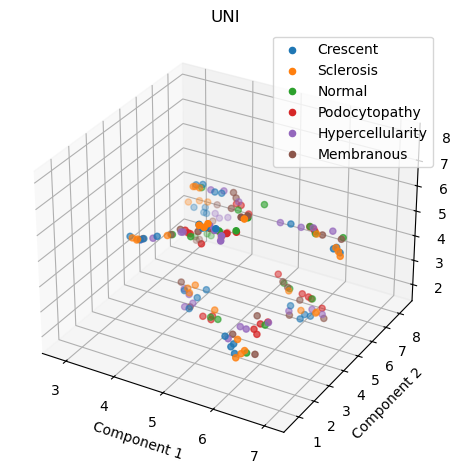

In [101]:
visualize_and_save("UNI")

# UNI2

[!] Plot saved to ./figs/UMAP/UNI2.png


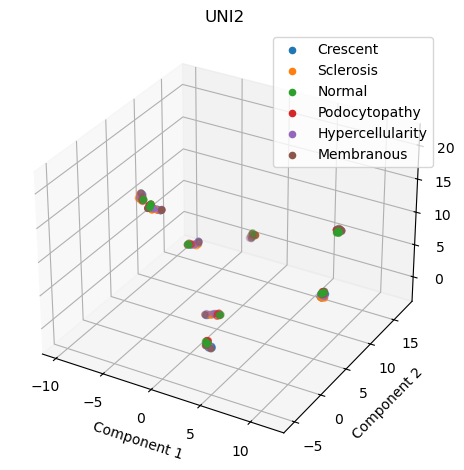

In [102]:
visualize_and_save("UNI2")

# Phikon

[!] Plot saved to ./figs/UMAP/Phikon.png


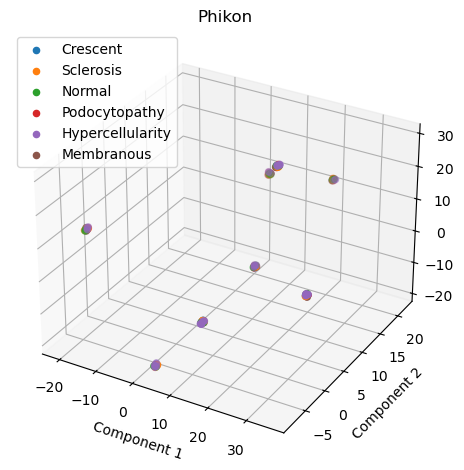

In [103]:
visualize_and_save("Phikon")

# PhikonV2

[!] Plot saved to ./figs/UMAP/PhikonV2.png


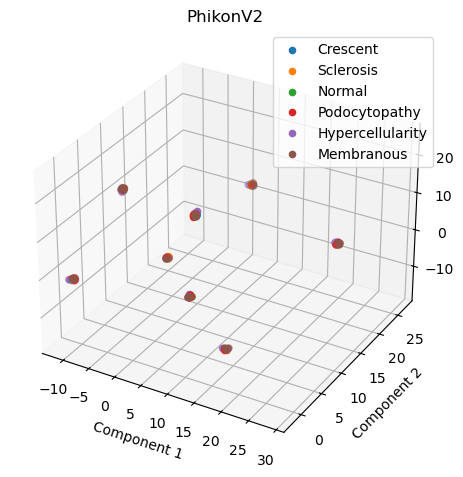

In [104]:
visualize_and_save("PhikonV2")

# MAE (Base)

[!] Plot saved to ./figs/UMAP/MAE-base-cls_token_only


<Figure size 1600x400 with 0 Axes>

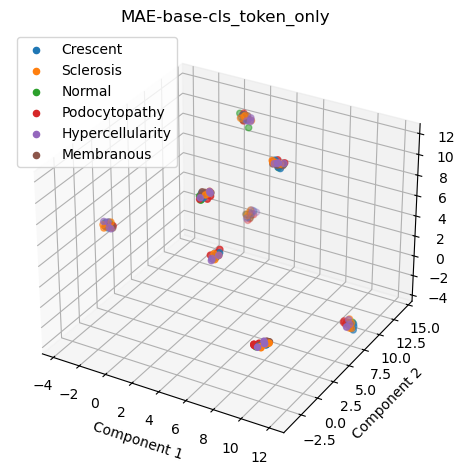

[!] Plot saved to ./figs/UMAP/MAE-base-mean


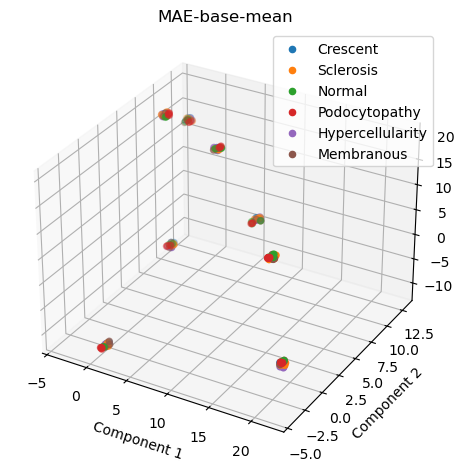

[!] Plot saved to ./figs/UMAP/MAE-base-mean+cls


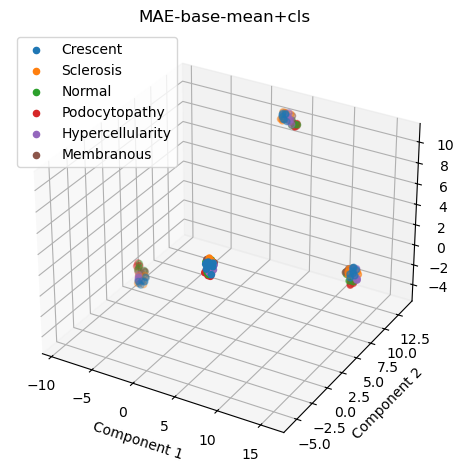

In [105]:
plt.figure(figsize=(16, 4)) 

mae_size = 'base'
for idx, arch in enumerate(("cls_token_only", "mean", "mean+cls")):
    embedding_path = f"../extracted-embeddings/terumo-val/mae/mae-{mae_size}-{arch}/MAE-{mae_size}-{arch}.npy"
    info_path = f"../extracted-embeddings/terumo-val/mae/mae-{mae_size}-{arch}/MAE-{mae_size}-{arch}_info.npy"
    visualize_embedding(f"MAE-{mae_size}-{arch}", embedding_path, info_path, dims=3, output_file=f"./figs/UMAP/MAE-{mae_size}-{arch}").show()

# MAE (Large)

[!] Plot saved to ./figs/UMAP/MAE-large-cls_token_only


<Figure size 1600x400 with 0 Axes>

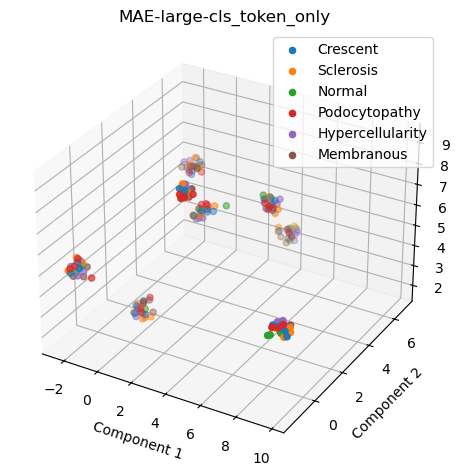

[!] Plot saved to ./figs/UMAP/MAE-large-mean


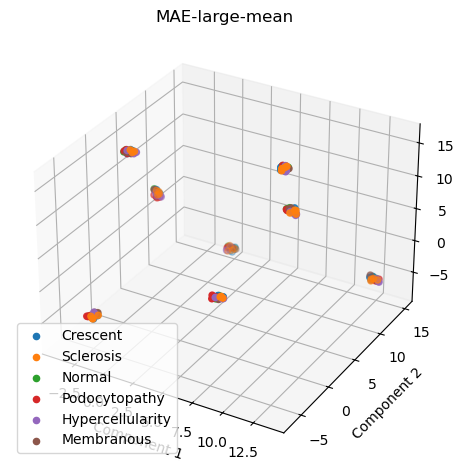

[!] Plot saved to ./figs/UMAP/MAE-large-mean+cls


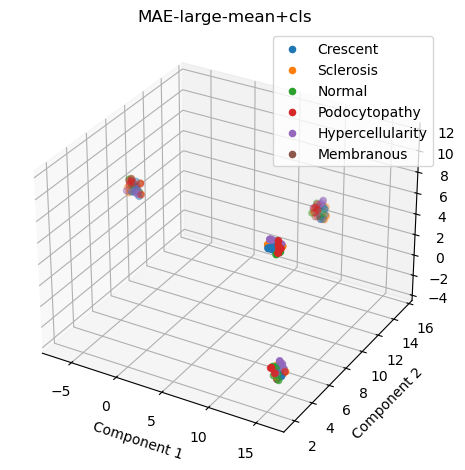

In [107]:
plt.figure(figsize=(16, 4)) 

mae_size = 'large'
for idx, arch in enumerate(("cls_token_only", "mean", "mean+cls")):
    embedding_path = f"../extracted-embeddings/terumo-val/mae/mae-{mae_size}-{arch}/MAE-{mae_size}-{arch}.npy"
    info_path = f"../extracted-embeddings/terumo-val/mae/mae-{mae_size}-{arch}/MAE-{mae_size}-{arch}_info.npy"
    visualize_embedding(f"MAE-{mae_size}-{arch}", embedding_path, info_path, dims=3, output_file=f"./figs/UMAP/MAE-{mae_size}-{arch}").show()

# MAE (Large - AE Reduced)

mae-large-full-reduced-1024 ['mae', 'large', 'full', 'reduced', '1024']
[!] Plot saved to ./figs/UMAP/MAE-large-full-reduced-1024


<Figure size 1600x400 with 0 Axes>

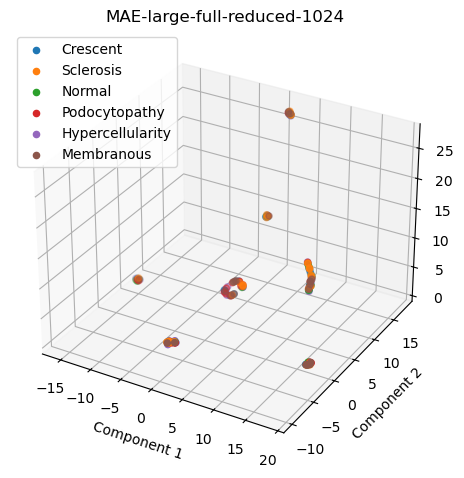

In [106]:
plt.figure(figsize=(16, 4))

mae_size = 'large'
mae_repr_method = 'full'


embedding_path = f"../extracted-embeddings/terumo-val/mae/ae_reduced/MAE-{mae_size}-{mae_repr_method}-reduced-1024.npy"
info_path = f"../extracted-embeddings/terumo-val/mae/mae-{mae_size}-{mae_repr_method}/MAE-{mae_size}-{mae_repr_method}_info.npy"

visualize_embedding(f"MAE-{mae_size}-{mae_repr_method}-reduced-1024", embedding_path, info_path, dims=3, output_file=f"./figs/UMAP/MAE-{mae_size}-{mae_repr_method}-reduced-1024").show()
